# Advanced Tutorial 16: Model Robustness

## Overview
In this tutorial, we will discuss the following topics:
* [How robust a model is at testing?](#ta16model_robustness)
* [How Data augmentation can help improve rotation robustness?](#ta16how_to_improve)
    * [The effect of applying shear augmentation](#ta16shear)
    * [The effect of applying rotation augmentation](#ta16rotation)
    * [Model Comparison](#ta16comparison)

<a id='ta16model_robustness'></a>
## How robust a model is at testing?

Robustness is the ability of a model to estimate reliably when inputs are influenced by different conditions or when model’s assumptions are not fully satisfied.
In this tutorial we are going to introduce model robustness and how we can use FastEstimator Search API and Visualization API to check model robustness.

In this tutorial, we will test model’s capability at handling rotation varieties. First, let’s design a generic `get_estimator` function to be used in all our experiments in this tutorial and ensure that we use same test and train set for each experiment. 

In [1]:
import fastestimator as fe
import os
import tempfile

from fastestimator.dataset.data import cifair10

from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize
from fastestimator.op.numpyop.multivariate import Rotate, Affine
from fastestimator.architecture.pytorch import LeNet
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import ModelSaver
from fastestimator.trace.metric import Accuracy



def get_estimator(
    save_dir,
    weight_path=None,
    model_name='robust',
    train_rotate=None,
    test_rotate=None,
    train_shear=None,
    epochs=24,
    visualize=False):
    
    train_data, eval_data = cifair10.load_data()
    test_data = eval_data.split(0.5, seed = 0)
    
    numpy_op = []
    
    if train_shear is not None:
        numpy_op.append(Affine(image_in="x", shear=train_shear, mode="train", border_handling='constant', fill_value=0))
    if train_rotate is not None:
        numpy_op.append(Affine(image_in="x", rotate=train_rotate, mode="train", border_handling='constant', fill_value=0))

    pipeline = fe.Pipeline(train_data=train_data,
                           eval_data=eval_data,
                           test_data=test_data,
                           batch_size=32,
                           ops=numpy_op +[Rotate(image_in="x", limit=[test_rotate, test_rotate], mode="test"),
                                Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
                                ChannelTranspose(inputs="x", outputs="x")
                            ])
    
    
    model = fe.build(model_fn=lambda: LeNet(input_shape=(3, 32, 32)), optimizer_fn="adam", weights_path=weight_path, model_name=model_name)

    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce", mode="train")
    ])

    traces = [
            Accuracy(true_key="y", pred_key="y_pred"),
            ModelSaver(model=model, save_dir=save_dir, frequency=epochs)
        ]
    
    estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=epochs, traces=traces)
    if visualize:
        return estimator, pipeline
    else:
        return estimator


Let's train a model without any augmentation.


In [2]:
save_dir = tempfile.mkdtemp()
est, no_aug_pipe = get_estimator(save_dir, weight_path=None, model_name='Without_augmentation', epochs=3, visualize=True)
est.fit()

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 2.3139648;
FastEstimator-Train: step: 100; ce: 1.8486447; steps/sec: 131.89;
FastEstimator-Train: step: 200; ce: 1.911953; steps/sec: 165.67;
FastEstimator-Train: step: 300; ce: 1.5032201; steps/sec: 158.52;
FastEstimator-Train: step: 400; ce: 1.4315889; steps/sec: 170.51;
FastEstimator-Train: step: 500; ce: 1.3999066; steps/sec: 173.06;
FastEstimator-Train:

Now that we have trained our model without any augmentations, let's load the trained model and test its performance on test set while the input images are rotated at various degrees. We will use FastEstimator Search API to accomplish this.

First, let's define a generic evaluation function for Grid Search

In [5]:
from fastestimator.search.visualize import visualize_search
from fastestimator.search import GridSearch

def score_fn(search_idx, rotate, weight_path, save_dir, field_name):
    est = get_estimator(save_dir, weight_path=weight_path, test_rotate=rotate, epochs=3, visualize=False)
    hist = est.test(summary="myexp")
    acc = float(hist.history["test"]["accuracy"][0])
    return {field_name: acc}


We take a range of rotation from 0 to 360 degrees(at an interval of 10) and use Grid Search to pass the rotation angles the estimator function

In [6]:
weight_path = os.path.join(save_dir, 'Without_augmentation_epoch_3.pt')
rot = list(range(0, 360, 10))

no_aug_grid_search = GridSearch(eval_fn=lambda search_idx, rotate: score_fn(search_idx, rotate, weight_path, save_dir, field_name="Accuracy without Augmentation"), params={"rotate": rot})

no_aug_grid_search.fit()


FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.679; ce: 0.9338175;
FastEstimator-Search: Evaluated {'rotate': 0, 'search_idx': 1}, result: {'Accuracy without Augmentation': 0.679}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.6004; ce: 1.1807765;
FastEstimator-Search: Evaluated {'rotate': 10, 'search_idx': 2}, result: {'Accuracy without Augmentation': 0.6004}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5148; ce: 1.479284;
FastEstimator-Search: Evaluated {'rotate': 20, 'search_idx': 3}, result: {'Accuracy without Augmentation': 0.5148}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch:

Let's visualize how our model performs when tested on rotated images

In [7]:
visualize_search(search=no_aug_grid_search, title="Model Robustness Without Augmentation")

<a id='ta16how_to_improve'></a>
## How Data augmentation can help improve rotation robustness?

It is clear from last experiment that as the angle of rotation increases the performance drops. This shows that the trained model is not robust to rotation while testing. Can we improve rotation robustness by augmentating training images?


<a id='ta16shear'></a>
### The effect of applying shear augmentation

Shear is augmentation to move one or two sides of the image, turning a square or rectangle image into a trapezoidal image. Would training a model with Shear augmentation while training make it robust to rotation? Let's visualize the shear operation first.


In [8]:
est, shear_pipe = get_estimator(save_dir, weight_path=None, model_name='Shear', train_shear=45, epochs=3, visualize=True)


FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.


c:\Users\223043597\AppData\Local\Programs\Python\Python38\lib\site-packages\albumentations\imgaug\transforms.py:337: FutureWarning:

This IAAAffine is deprecated. Please use Affine instead



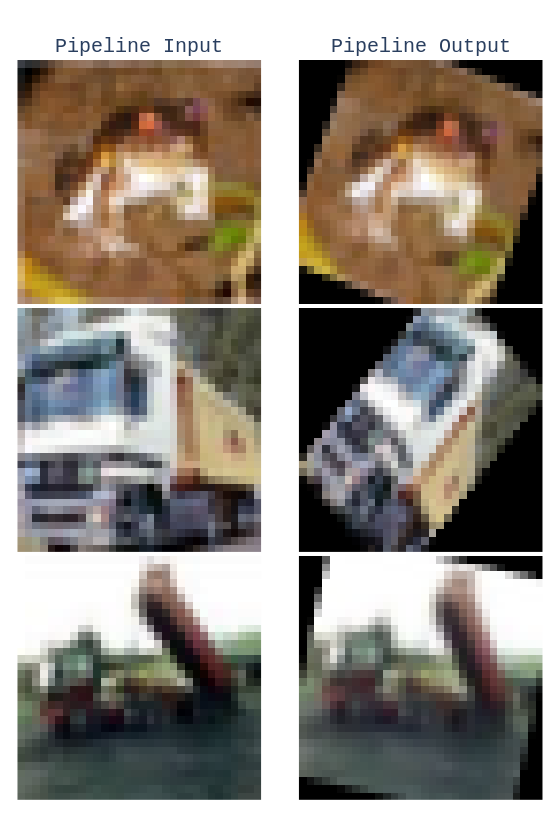

In [ ]:
from fastestimator.util import GridDisplay, BatchDisplay

shear_results = shear_pipe.get_results()
no_aug_results = no_aug_pipe.get_results()

sample_num = 3

fig = GridDisplay([
    BatchDisplay(image=no_aug_results['x'][0:sample_num], title="Pipeline Input"),
    BatchDisplay(image=shear_results['x'][0:sample_num], title="Pipeline Output")
])
fig.show()


Now that we have visualized shear operation , let us train a model while applying random shear operation in range [-45, 45] degrees.

In [9]:
est.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 2.3378026;
FastEstimator-Train: step: 100; ce: 2.0335546; steps/sec: 27.31;
FastEstimator-Train: step: 200; ce: 1.779464; steps/sec: 28.52;
FastEstimator-Train: step: 300; ce: 1.7361405; steps/sec: 30.22;
FastEstimator-Train: step: 400; ce: 1.4763032; steps/sec: 27.62;
FastEstimator-Train: step: 500; ce: 1.7565935; steps/sec: 28.97;
FastEstimator-Train: step: 600; ce: 1.3033587; steps/sec: 28.36;
FastEstimator-Train: step: 700; ce: 1.6728466; steps/sec: 3

Now that we have trained this new model of ours, let's use Grid Search again to test the performance of the model while the input images are rotated in range 0 to 360 degrees(at an interval of 10)

In [10]:
weight_path = os.path.join(save_dir, 'Shear_epoch_3.pt')

rot = list(range(0, 360, 10))

shear_grid_search = GridSearch(eval_fn=lambda search_idx, rotate: score_fn(search_idx, rotate, weight_path, save_dir, field_name="Shear Accuracy"), params={"rotate": rot})

shear_grid_search.fit()

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5868; ce: 1.163596;
FastEstimator-Search: Evaluated {'rotate': 0, 'search_idx': 1}, result: {'Shear Accuracy': 0.5868}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5896; ce: 1.1458238;
FastEstimator-Search: Evaluated {'rotate': 10, 'search_idx': 2}, result: {'Shear Accuracy': 0.5896}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5776; ce: 1.2027122;
FastEstimator-Search: Evaluated {'rotate': 20, 'search_idx': 3}, result: {'Shear Accuracy': 0.5776}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5344; ce: 1.317542;
FastEst

In [11]:
visualize_search(search=shear_grid_search, title="Model Robustness With Shear")

<a id='ta16rotation'></a>
### The effect of applying rotation augmentation

To test this out let's train the model while randomly rotating images in range[-90, 90]. First, let's visalize how the rotation operation looks.

In [12]:
est,rotate_pipe = get_estimator(save_dir, weight_path=None, model_name='Rotation', train_rotate=90, epochs=3, visualize=True)

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.


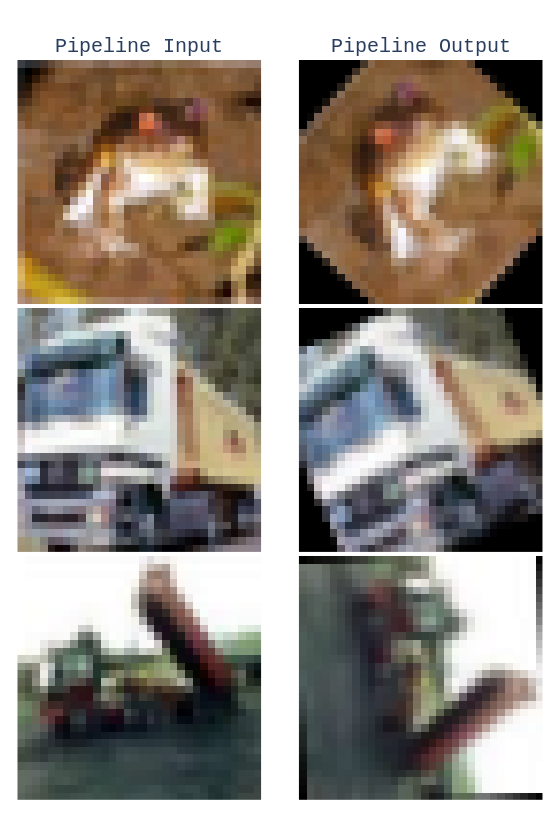

In [ ]:
rotate_results = rotate_pipe.get_results()
no_aug_results = no_aug_pipe.get_results()

sample_num = 3

fig = GridDisplay([
    BatchDisplay(image=no_aug_results['x'][0:sample_num], title="Pipeline Input"),
    BatchDisplay(image=rotate_results['x'][0:sample_num], title="Pipeline Output")
])
fig.show()


In [13]:
est.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 2.3045702;
FastEstimator-Train: step: 100; ce: 2.095564; steps/sec: 27.38;
FastEstimator-Train: step: 200; ce: 1.939709; steps/sec: 23.41;
FastEstimator-Train: step: 300; ce: 2.0294816; steps/sec: 22.91;
FastEstimator-Train: step: 400; ce: 1.9908059; steps/sec: 28.18;
FastEstimator-Train: step: 500; ce: 1.6164654; steps/sec: 30.38;
FastEstimator-Train: step: 600; ce: 1.7250518; steps/sec: 29.14;
FastEstimator-Train: step: 700; ce: 1.8487082; steps/sec: 22

Let us use Grid Search again to test the performance of the model while the input images are rotated in range 0 to 360 degrees(at an interval of 10)

In [14]:
weight_path = os.path.join(save_dir, 'Rotation_epoch_3.pt')

rot = list(range(0, 360, 10))

rotation_grid_search = GridSearch(eval_fn=lambda search_idx, rotate: score_fn(search_idx, rotate, weight_path, save_dir, field_name="Rotation Accuracy"), params={"rotate": rot})

rotation_grid_search.fit()

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5154; ce: 1.3517281;
FastEstimator-Search: Evaluated {'rotate': 0, 'search_idx': 1}, result: {'Rotation Accuracy': 0.5154}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5284; ce: 1.2975515;
FastEstimator-Search: Evaluated {'rotate': 10, 'search_idx': 2}, result: {'Rotation Accuracy': 0.5284}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.526; ce: 1.2994927;
FastEstimator-Search: Evaluated {'rotate': 20, 'search_idx': 3}, result: {'Rotation Accuracy': 0.526}
FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
FastEstimator-Test: step: None; epoch: 3; accuracy: 0.5262; ce: 1.3059227

In [15]:
visualize_search(search=rotation_grid_search, title="Model Robustness With Rotation")

The above plot proves that if we introduce random rotation while training, we can make model more robust to rotation. The model is still not robust to the range [90, 270] while testing since it was not trained on the same.


<a id='ta16comparison'></a>
### Model Comparison

Let's compare all the trained model to compare model robustness to rotation

In [16]:
def comparison_fn(search_idx, rotate, no_aug_results, shear_results, rotation_results):
    acc = no_aug_results[rotate//10]['result']
    shear_acc = shear_results[rotate//10]['result']
    rotation_acc = rotation_results[rotate//10]['result']
    
    
    return {**acc, **shear_acc, **rotation_acc}

no_aug_results = no_aug_grid_search.get_search_summary()
shear_results = shear_grid_search.get_search_summary()
rotation_results = rotation_grid_search.get_search_summary()

rot = list(range(0, 360, 10))

model_comparison_grid_search = GridSearch(eval_fn=lambda search_idx, rotate: comparison_fn(search_idx, rotate, no_aug_results, shear_results, rotation_results), params={"rotate": rot})

model_comparison_grid_search.fit()

FastEstimator-Search: Evaluated {'rotate': 0, 'search_idx': 1}, result: {'Accuracy without Augmentation': 0.679, 'Shear Accuracy': 0.5868, 'Rotation Accuracy': 0.5154}
FastEstimator-Search: Evaluated {'rotate': 10, 'search_idx': 2}, result: {'Accuracy without Augmentation': 0.6004, 'Shear Accuracy': 0.5896, 'Rotation Accuracy': 0.5284}
FastEstimator-Search: Evaluated {'rotate': 20, 'search_idx': 3}, result: {'Accuracy without Augmentation': 0.5148, 'Shear Accuracy': 0.5776, 'Rotation Accuracy': 0.526}
FastEstimator-Search: Evaluated {'rotate': 30, 'search_idx': 4}, result: {'Accuracy without Augmentation': 0.406, 'Shear Accuracy': 0.5344, 'Rotation Accuracy': 0.5262}
FastEstimator-Search: Evaluated {'rotate': 40, 'search_idx': 5}, result: {'Accuracy without Augmentation': 0.3202, 'Shear Accuracy': 0.4818, 'Rotation Accuracy': 0.5258}
FastEstimator-Search: Evaluated {'rotate': 50, 'search_idx': 6}, result: {'Accuracy without Augmentation': 0.2668, 'Shear Accuracy': 0.4222, 'Rotation Acc

In [17]:
visualize_search(search=model_comparison_grid_search, title="Model Robustness",groups=[['Accuracy without Augmentation','Shear Accuracy','Rotation Accuracy']])

It can be seen that by randomly introducing shear and rotation to the input images while training makes model more robust to rotation. So with augmentation we can make the model aware of rotation and increase robustness of the model.

`NOTE : All the three models compared above were trained only for 3 epochs on LeNet. One can achieve a much better performance by training long enough and choosing a different architecture.`
